<a href="https://colab.research.google.com/github/peterske/MATH-335-Copied/blob/main/bike_rentals_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Rentals Assignment

In [ ]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime

pd.set_option('display.max_columns', None)

data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

test_mini = True
if test_mini:
  mini = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv')

data.head()

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
0,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13
1,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32
2,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27
3,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10
4,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1


# Process Data

In [ ]:
# New features
data["total"] = data["casual"] + data["registered"]

# Preprocessing
def preprocessing(df: pd.DataFrame):

  ## Kelly's changes
  # one hot encode origin
  #df['season'] = df['season'].map({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
  #df = pd.get_dummies(df, columns=['season'], prefix='', prefix_sep='')

  #df['holiday'] = df['holiday'].map({1: 'Yes', 0: 'No'})
  #df = pd.get_dummies(df, columns=['holiday'], prefix='', prefix_sep='')

  #df['workingday'] = df['workingday'].map({1: 'Neither_Weekend_Holiday', 0: 'Otherwise'})
  #df = pd.get_dummies(df, columns=['workingday'], prefix='', prefix_sep='')

  # Commented Out with USED comments
  #df['weathersit'] = df['weathersit'].map({1: 'ClearAndCloudy', 2: 'MistyVersions', 3: 'LightPrecipitation', 4: 'HeavyPrecipitation'})
  #df = pd.get_dummies(df, columns=['weathersit'], prefix='', prefix_sep='')

  # Create a day_of_week column that scrapes the day of the week from dteday
  datetime_series = pd.Series(df['dteday'].apply(lambda x: datetime.strptime(x, '%m/%d/%y')))
  df['day_of_week'] = datetime_series.apply(lambda x: x.strftime('%a'))
  df['day_of_week'] = df['day_of_week'].map({'Sun': 1, 'Mon': 2, 'Tue': 3, 'Wed': 4, 'Thu': 5, 'Fri': 6, 'Sat': 7})

  # Create month, year, and year_month columns
  df['month'] = datetime_series.apply(lambda x: x.strftime('%b'))
  #df['month'] = pd.get_dummies(df, columns=['month'])

  df['year'] = datetime_series.apply(lambda x: x.strftime('%Y'))
  #df['year'] = pd.get_dummies(df, columns=['year'])

  df['year_month'] = df['year'].astype(str) + "_" + df['month'].astype(str)

  #df = pd.get_dummies(df, columns=['hr'])
  #df = pd.get_dummies(df, columns=['dteday'])
  # Average temps
  df['average_c'] = (df['feels_like_c'] + df['temp_c']) / 2
  return df

data = preprocessing(data)
mini = preprocessing(mini)


In [ ]:
def mapMonths(df: pd.DataFrame, columnName: str):
  return df[columnName].map({
      1:  'Jan', 2:  'Feb', 3:  'Mar',
      4:  'Apr', 5:  'May', 6:  'Jun',
      7:  'Jul', 8:  'Aug', 9:  'Sep',
      10: 'Oct', 11: 'Nov', 12: 'Dec'
  })

In [ ]:
def stratify_training(data: pd.DataFrame, features: list):
  data['dteday'] = data['dteday'].astype('datetime64')

  # Get test data from march and september
  test_months = ['2012_3', '2011_6', '2012_9', '2011_11']
  test_bikes = data.loc[(data['year_month'].isin(test_months))]
  
  # Save validation data from June and December
  validation_months = ['2011_1', '2011_4', '2012_7', '2011_10']
  val_bikes = data.loc[(data['year_month'].isin(validation_months))]

  # Remove test and validation data from the main set
  data = data.loc[(~data['year_month'].isin(test_months + validation_months))]

  # One-hot encode the months
  data['month'] = mapMonths(data, 'month')
  data = pd.get_dummies(data, columns=['month'], prefix="", prefix_sep="")

  # One hot encode the test and validation set
  test_bikes['month'] = mapMonths(test_bikes, 'month')
  test_bikes = pd.get_dummies(test_bikes, columns=['month'], prefix="", prefix_sep="")

  val_bikes['month'] = mapMonths(val_bikes, 'month')
  val_bikes = pd.get_dummies(val_bikes, columns=['month'], prefix="", prefix_sep="")

  # Create dummy values for the unused months
  test_bikes[['Jan', 'Feb', 'Apr', 'May', 'Jul', 'Aug', 'Oct', 'Nov']] = 0
  val_bikes[['Feb', 'Mar', 'May', 'Jun', 'Aug', 'Sep', 'Nov', 'Dec']] = 0
  data[['Dec']] = 0

  # X_train, X_test, y_train, y_test
  return data[features], test_bikes[features], data["total"], test_bikes['total']

# Train the Model

In [ ]:
# Set X and y
features = ['season', 'hr', 'holiday', 'workingday', 'weathersit', 'hum', 'windspeed', 'average_c', 'day_of_week']
data['total'] = data['registered'] + data['casual']
X = data[features]
y = data['total']

do_stratify_training = False

if do_stratify_training:
  X_train, X_test, y_train, y_test = stratify_training(data, features)

else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# Transform training data
X_train = norm.transform(X_train)

# Transform testing data
X_test = norm.transform(X_test)

if test_mini:
  mini = norm.transform(mini[features])

In [ ]:
# Build the Model
model = keras.Sequential()

# Activation Functions:
# 'sigmoid'
# 'tanh'
# 'relu'
# layers.LeakyReLu(alpha=.01) 
# layers.PReLU()
# 'elu'


model.add(layers.Dense(128, input_dim=len(X_train[0]), activation='sigmoid'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(64, activation='sigmoid'))

model.add(layers.Dense(1, activation='relu'))

model.summary()

# model.add(layers.Dense(128, input_dim=len(X_train[0]), activation='sigmoid'))
# model.add(layers.Dropout(.5))
# model.add(layers.Dense(256, activation='tanh'))
# model.add(layers.Dense(128, activation='sigmoid'))
# model.add(layers.Dense(1, activation='relu'))

# model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1280      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26,113
Trainable params: 26,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

msle = tf.keras.losses.MeanSquaredLogarithmicError()

model.compile(loss=msle, optimizer=opt, metrics=['msle'])

In [ ]:
# Train the Model
early_stop = keras.callbacks.EarlyStopping(monitor='val_msle', patience=30)
history = model.fit(X_train, y_train, epochs=2000, validation_split=.35, batch_size=20, callbacks=[early_stop], shuffle=False)

hist = pd.DataFrame(history.history)

Epoch 1/2000
433/433 [==============================] - 3s 5ms/step - loss: 3.5551 - msle: 3.5551 - val_loss: 2.4951 - val_msle: 2.4951
Epoch 2/2000
433/433 [==============================] - 1s 3ms/step - loss: 2.2587 - msle: 2.2587 - val_loss: 2.1616 - val_msle: 2.1616
Epoch 3/2000
433/433 [==============================] - 2s 4ms/step - loss: 2.0902 - msle: 2.0902 - val_loss: 2.0744 - val_msle: 2.0744
Epoch 4/2000
433/433 [==============================] - 2s 5ms/step - loss: 2.0439 - msle: 2.0439 - val_loss: 2.0468 - val_msle: 2.0468
Epoch 5/2000
433/433 [==============================] - 2s 5ms/step - loss: 2.0303 - msle: 2.0303 - val_loss: 2.0380 - val_msle: 2.0380
Epoch 6/2000
433/433 [==============================] - 1s 3ms/step - loss: 2.0268 - msle: 2.0268 - val_loss: 2.0354 - val_msle: 2.0354
Epoch 7/2000
433/433 [==============================] - 1s 3ms/step - loss: 2.0262 - msle: 2.0262 - val_loss: 2.0346 - val_msle: 2.0346
Epoch 8/2000
433/433 [==========================

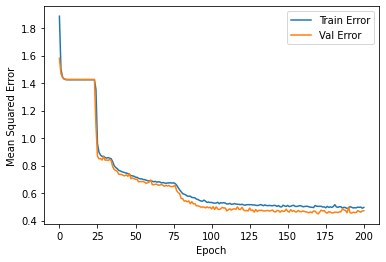

In [ ]:
# Function to plot the training results
def plot_history():
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['index'], np.sqrt(hist['msle']), label = 'Train Error')
  plt.plot(hist['index'], np.sqrt(hist['val_msle']), label = 'Val Error')
  plt.legend()
  
hist = hist.reset_index()
plot_history()

In [ ]:
predictions = np.round(model.predict(X_test),1)

104/104 [==============================] - 0s 2ms/step


In [ ]:
# Make predictions on mini
if test_mini:
  mini_predictions = pd.DataFrame(np.floor(model.predict(np.asarray(mini))),columns=['predictions'])
  
  mini_predictions.to_csv("team2_module4-predictions.csv", index=False)

24/24 [==============================] - 0s 2ms/step


In [ ]:
rmse = mean_squared_error(y_test, predictions, squared = False)
r2 = r2_score(y_test, predictions)

#print(f'Median Number of Registrations:  {round(median, 0)}')
#print(f'Average Number of Registrations: {round(mean, 0)}')
print(f'RMSE:                            {round(rmse, 2)}')
print(f'R2 Score:                        {round(r2, 5)}')

RMSE:                            84.35
R2 Score:                        0.77614


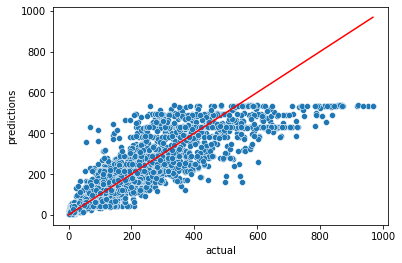

In [ ]:
pred = pd.DataFrame(predictions, columns=['predictions'])
pred['actual'] = y_test.tolist()
pred['difference'] = np.sqrt(pred['actual']) - np.sqrt(pred['predictions'])

xlims=(0, pred['actual'].max())
ax = sns.scatterplot(data=pred, x='actual', y='predictions')
ax.plot(xlims, xlims, color = 'r')
plt.show()